In [31]:
%load_ext autoreload
%autoreload 1
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
import os, sys
from os.path import join as pjoin
sys.path.insert(0, pjoin(os.path.pardir, 'webapi'))
sys.path.insert(0, pjoin(os.path.pardir, os.path.pardir, 'mcdose'))
import numpy as np
import h5py
from bson import ObjectId
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt

os.environ['CUDA_VISIBLE_DEVICES'] = ""
%aimport loaders
%aimport mcdose
from mcdose.visualize import vis_slice
import database
from api_enums import DBCOLLECTIONS

In [33]:
# connect to database
database.init_dbclient(port=27099, auth=['root', 'rootpass'])
database.InitDataStorage(root='/media/hdd2/g4sim/data')

In [34]:
# get list of simdocs
beam_id = '5e15407ec9c073745a01ced3'
filter = {'_id': ObjectId(beam_id)}
beamdoc = database.db[DBCOLLECTIONS.BEAMPHOTON].find_one(filter)

# get sim_ids
sim_ids = []
filter = {'beam_id': ObjectId(beam_id), 'num_particles': 2000, 'magnetic_field.2': 1.5}
for simdoc in database.db[DBCOLLECTIONS.SIMULATION].find(filter):
    sim_ids.append(simdoc['_id'])
print(len(sim_ids))

285


In [35]:
def draw_coordsys(orig_geom, orig_label, proc_geom, proc_label, unprocessor):
    import math
    import numpy as np
    import scipy.ndimage as ndimage
    from matplotlib import patches
    colors = ['red', 'blue', 'green', 'orange', 'black', 'purple']
    # calculate corresponding slices
    proc_ctr_slice = proc_geom.shape[0]//2
    sp = unprocessor.proc_csys['start'][2]
    so = unprocessor.orig_csys['start'][2]
    sizep = unprocessor.proc_csys['size'][2]
    spacep = unprocessor.proc_csys['spacing'][2]
    spaceo = unprocessor.orig_csys['spacing'][2]
    orig_ctr_slice = int((sp-so+0.5*sizep*spacep)/spaceo)
    # pack up data
    data = [
        (unprocessor.orig_csys, orig_geom[orig_ctr_slice], orig_label[orig_ctr_slice]),
        (unprocessor.proc_csys, proc_geom[proc_ctr_slice], proc_label[proc_ctr_slice]),
    ]
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    ax.grid()
    for ii, (clr, (csys, geom, label)) in enumerate(zip(colors[:len(data)], data)):
        # draw coordinate system bounds
        ax.text(csys['start'][0]+10, csys['start'][1]+10, str(ii), horizontalalignment='left', verticalalignment='top', zorder=99+ii, color=clr)
        ax.add_patch(patches.Circle((csys['start'][:2]), radius=8, zorder=99+ii, facecolor=clr, edgecolor='black'))
        ax.add_patch(patches.Rectangle((csys['start']), csys['size'][0]*csys['spacing'][0], csys['size'][1]*csys['spacing'][1],
                                       fill=False, angle=0 if ii==0 else unprocessor.angle_radian*180.0/math.pi, color=clr, linewidth=2,
                                       zorder=99+ii))
        _, aims = vis_slice(geom, label, thresh=1e-3, ax=ax)
        for jj, aim in enumerate(aims):
            aim.set_extent((
                csys['start'][0], csys['start'][0]+csys['size'][0]*csys['spacing'][0],
                csys['start'][1]+csys['size'][1]*csys['spacing'][1], csys['start'][1],
            ))
            aim.set_alpha(0.8)
    ax.tick_params(axis='x', labeltop=True, labelbottom=False, top=True, bottom=False)
    ax.autoscale_view()

In [36]:
simdoc = database.db[DBCOLLECTIONS.SIMULATION].find_one({'_id': sim_ids[140]})

min:  -240.4294985444228
max:  2522.6562094405235
mean:  0.11269426521718186
std:  4.114490449412109
orig coordsys:  {'spacing': [2.5, 2.5, 2.5], 'start': [-240.0, -364.0, -657.0], 'size': [192, 113, 111]}
new coordsys:   {'spacing': [2.5, 2.5, 2.5], 'start': array([  73.42230002, -104.10743449, -534.41964833]), 'size': array([ 25, 111,   9])}


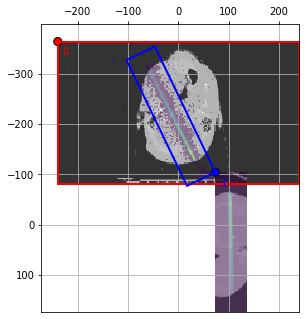

In [44]:
# Test Vanilla Loading
ctx = 4
arrayloader_orig = loaders.ArrayLoader(reorient=False, get_geom=True, get_label=True)
arrayloader = loaders.ArrayLoader(reorient=True, context=(12,55,ctx), get_geom=True, get_label=True, reversible=True)

(orig_inputs, orig_geom, orig_label) = arrayloader_orig(simdoc)
(inputs, geom, label), unprocessor = arrayloader(simdoc)
ungeom, uninput, unlabel = unprocessor(geom), unprocessor(inputs[0]), unprocessor(label)

diff = orig_label-unlabel
print('min: ', np.amin(diff))
print('max: ', np.amax(diff))
print('mean: ', np.mean(diff))
print('std: ', np.std(diff))

print('orig coordsys: ', unprocessor.orig_csys)
print('new coordsys:  ', unprocessor.proc_csys)
plt.close('all')
draw_coordsys(orig_geom, orig_label, geom, label, unprocessor)

%aimport mcdose.visualize
from mcdose.visualize import create_volume_dose_figure
#stackarr =  np.stack([
#        np.stack([
#            orig_label[sliceidx,...],
#            unlabel[sliceidx,...],
#            orig_label[sliceidx,...]-unlabel[sliceidx,...]
#        ], axis=0) for sliceidx in range(orig_label.shape[0])
#    ], axis=0)
#fig = create_volume_dose_figure( stackarr, dpi=200, return_fig=True, col_labels=['orig', 'unproc', 'orig-unproc'])
if False:
    sp = unprocessor.proc_csys['start'][2]
    so = unprocessor.orig_csys['start'][2]
    sizep = unprocessor.proc_csys['size'][2]
    spacep = unprocessor.proc_csys['spacing'][2]
    spaceo = unprocessor.orig_csys['spacing'][2]
    orig_ctr_slice = int((sp-so+0.5*sizep*spacep)/spaceo)
    for ii, slicenum in enumerate(range(orig_ctr_slice-ctx+1, orig_ctr_slice+ctx+2)):
        fig = plt.figure(figsize=(40,10))
        ax2, ax2, ax3, ax4 = fig.subplots(1,4)
        vmin, vmax = np.amin(orig_label[slicenum]), np.amax(orig_label[slicenum])
        vis_slice(orig_geom[slicenum], orig_label[slicenum], thresh=1e-3, ax=ax1)
        ax1.set_title('orig')
        vis_slice(geom[ii], label[ii], thresh=1e-3, ax=ax2)
        ax2.set_title('proc')
        vis_slice(ungeom[slicenum], unlabel[slicenum], thresh=1e-1, ax=ax3)
        ax3.set_title('unproc')
        aims = vis_slice(orig_geom[slicenum], orig_label[slicenum]-unlabel[slicenum], thresh=1e-3, ax=ax4)
        ax4.set_title('orig-unproc')
        for ax in fig.axes:
            for imidx, im in enumerate(ax.get_images()):
                if imidx:
                    im.set_clim(vmin, vmax)
        plt.colorbar(aims[1][1])

# Interp (order=0)
* min:  -1212.7460182380491
* max:  2522.6562094405235
* mean:  0.11259289129716582
* std:  5.02720987591336
# Interp (order=1)
* min:  -350.08847751130423
* max:  2522.6562094405235
* mean:  0.11226965856608262
* std:  4.784998557642218
# INTERP (order=2)
* min:  -240.4294985444228
* max:  2522.6562094405235
* mean:  0.11269426521718186
* std:  4.114490449412109